# Is this a chart or a map? (30DayMapChallenge 2023)
### Charging Stations for Electric Cars in Berlin
This notebook creates my contribution to day 28 of the [30DayMapChallenge 2023](https://30daymapchallenge.com/): "Is this a chart or a map?". Inspired by a [USGS map](https://twitter.com/USGS_DataSci/status/1645049420805820417), I wanted to place ribbons with histograms or lollipop plots to the sides of a gridded map.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import seaborn as sns
import cmcrameri.cm as cmc # https://www.fabiocrameri.ch/colourmaps/


I started in QGIS: pulling the location of charging stations from the WFS service of Geoportal Berlin, generating a grid (spacing 1 km) and counting the location per grid cell.

In [2]:
fn = "data/ladesaeulen.gpkg"
fiona.listlayers(fn)

['fiss_lades_standort', 'grid-hex', 'grid-berlin', 'count-hex', 'count-square']

In [3]:
gdf = gpd.read_file(fn, layer='count-square')
gdf.head()

,id,left,top,right,bottom,NUMPOINTS,geometry
0,28,369761.359526,5.810889e+06,370761.359526,5.809889e+06,0.0,"POLYGON ((369761.360 5810889.388, 370761.360 5..."
1,29,369761.359526,5.809889e+06,370761.359526,5.808889e+06,0.0,"POLYGON ((369761.360 5809889.388, 370761.360 5..."
2,30,369761.359526,5.808889e+06,370761.359526,5.807889e+06,0.0,"POLYGON ((369761.360 5808889.388, 370761.360 5..."
3,63,370761.359526,5.814889e+06,371761.359526,5.813889e+06,0.0,"POLYGON ((370761.360 5814889.388, 371761.360 5..."
4,64,370761.359526,5.813889e+06,371761.359526,5.812889e+06,0.0,"POLYGON ((370761.360 5813889.388, 371761.360 5..."


In [4]:
gdf['NUMPOINTS'].max()

64.0

The columns left, top, right, buttom are the coordinates of the grid cells. Let's calculate the center of the cells.

In [5]:
gdf['center_x'] = gdf['left'] + (gdf['right'] - gdf['left']) / 2
gdf['center_y'] = gdf['bottom'] + (gdf['top'] - gdf['bottom']) / 2
gdf.head()

,id,left,top,right,bottom,NUMPOINTS,geometry,center_x,center_y
0,28,369761.359526,5.810889e+06,370761.359526,5.809889e+06,0.0,"POLYGON ((369761.360 5810889.388, 370761.360 5...",370261.359526,5.810389e+06
1,29,369761.359526,5.809889e+06,370761.359526,5.808889e+06,0.0,"POLYGON ((369761.360 5809889.388, 370761.360 5...",370261.359526,5.809389e+06
2,30,369761.359526,5.808889e+06,370761.359526,5.807889e+06,0.0,"POLYGON ((369761.360 5808889.388, 370761.360 5...",370261.359526,5.808389e+06
3,63,370761.359526,5.814889e+06,371761.359526,5.813889e+06,0.0,"POLYGON ((370761.360 5814889.388, 371761.360 5...",371261.359526,5.814389e+06
4,64,370761.359526,5.813889e+06,371761.359526,5.812889e+06,0.0,"POLYGON ((370761.360 5813889.388, 371761.360 5...",371261.359526,5.813389e+06


Calculate the sum of each row / column

In [6]:
gx = gdf.groupby("center_x")["NUMPOINTS"].sum().reset_index()
gy = gdf.groupby("center_y")["NUMPOINTS"].sum().reset_index()

Calculate max of each row / column (could be used instead of sum for the ribbon charts)

In [7]:
maxx = gdf.groupby("center_x")["NUMPOINTS"].max().reset_index()
maxy = gdf.groupby("center_y")["NUMPOINTS"].max().reset_index()

## First map
It took me a while with trial and error to get the subplots to be of the correct size and with matching axes...

/home/riannek/miniconda3/envs/forge/lib/python3.10/site-packages/geopandas/plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


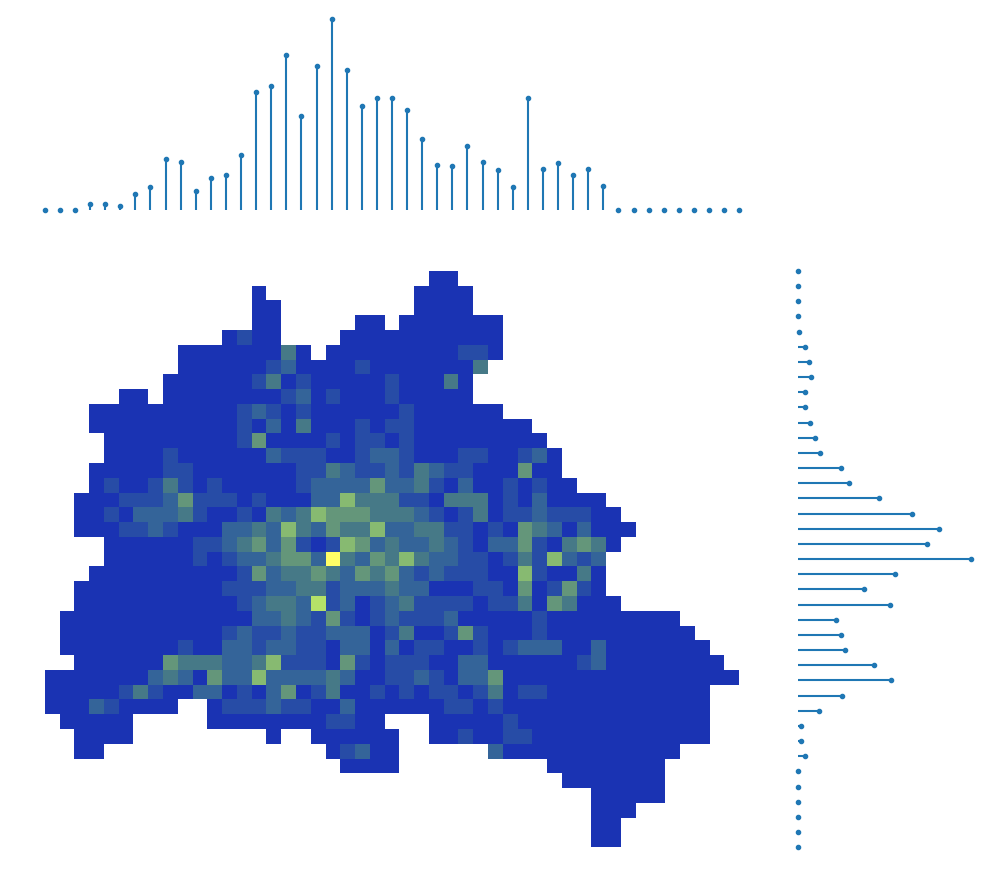

In [8]:

subplotratio = 4 # Map is subplotratio times larger than ribbons

fig, axs = plt.subplots(2,2, figsize=(10,10), layout="tight",   
                        width_ratios=[subplotratio,1], 
                        height_ratios=[1,subplotratio],
                        )

# Use the plotting function of geopandas to plot the map, classification scheme is fisher_jenks
gdf.plot(column='NUMPOINTS', scheme='fisher_jenks', k=8,cmap=cmc.imola, ax=axs[1,0])

axs[0,0].vlines(x=gx["center_x"], ymin=0, ymax=gx["NUMPOINTS"])
axs[0,0].plot(gx["center_x"], gx["NUMPOINTS"], ".")

axs[1,1].hlines(y=gy["center_y"], xmin=0, xmax=gy["NUMPOINTS"])
axs[1,1].plot(gy["NUMPOINTS"], gy["center_y"], ".")

# Force the right ribbon to be the same height as the map

mapheight = axs[1,0].get_ylim()[1] - axs[1,0].get_ylim()[0]
mapwidth = axs[1,0].get_xlim()[1] - axs[1,0].get_xlim()[0]

axs[1,1].set_box_aspect((mapheight * subplotratio) / mapwidth )


for ax in axs.ravel():
    ax.set_axis_off()


## Find out more about the data

In [9]:
gx['NUMPOINTS'].max()

144.0

In [10]:

gx['center_x'].loc[gx['NUMPOINTS'].idxmax()]

389261.3595258051

In [11]:
gx['center_x'].loc[19]

389261.3595258051

In [12]:
gy.head()

,center_y,NUMPOINTS
0,5.799389e+06,0.0
1,5.800389e+06,0.0
2,5.801389e+06,0.0
3,5.802389e+06,0.0
4,5.803389e+06,0.0


## Make the plot prettier
Use batlow as cmap, add title, legend and anotations, change the font, ...

/home/riannek/miniconda3/envs/forge/lib/python3.10/site-packages/geopandas/plotting.py:777: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


Text(-50, -50, 'Sum of 206')

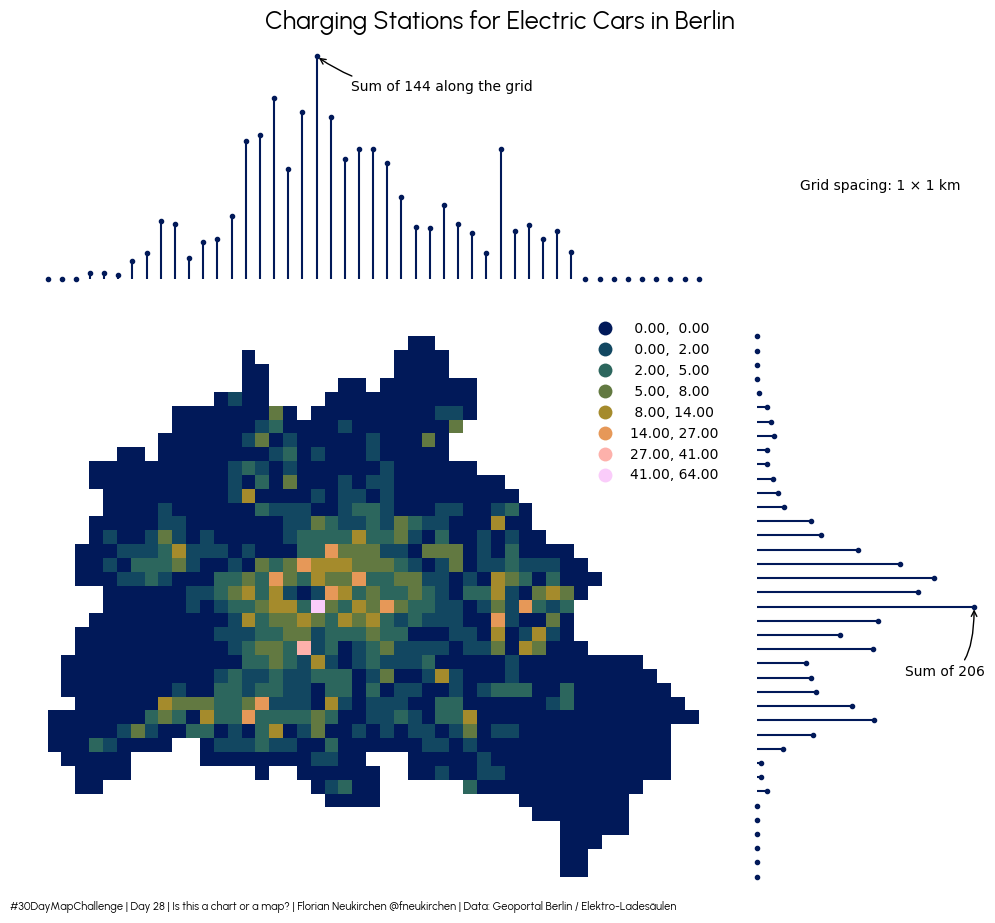

In [13]:
subplotratio = 3 # Map is subplotratio times larger than ribbons

font = 'Urbanist'

cmap = cmc.batlow
color = '#011959'


fig, axs = plt.subplots(2,2, figsize=(10,10), layout="tight",   
                        width_ratios=[subplotratio,1], 
                        height_ratios=[1,subplotratio],
                        )

fig.suptitle('Charging Stations for Electric Cars in Berlin', fontsize=18, fontname=font)

# Use the plotting function of geopandas to plot the map, classification scheme is fisher_jenks
gdf.plot(column='NUMPOINTS', scheme='fisher_jenks', k=8,cmap=cmap, ax=axs[1,0], legend=True)

axs[0,0].vlines(x=gx["center_x"], ymin=0, ymax=gx["NUMPOINTS"], color=color)
axs[0,0].plot(gx["center_x"], gx["NUMPOINTS"], ".", color=color)

axs[1,1].hlines(y=gy["center_y"], xmin=0, xmax=gy["NUMPOINTS"], color=color)
axs[1,1].plot(gy["NUMPOINTS"], gy["center_y"], ".", color=color)

# Force the right ribbon to be the same height as the map

mapheight = axs[1,0].get_ylim()[1] - axs[1,0].get_ylim()[0]
mapwidth = axs[1,0].get_xlim()[1] - axs[1,0].get_xlim()[0]

axs[1,1].set_box_aspect((mapheight * subplotratio) / mapwidth )

# Swithc of x,y axis for all subplots

for ax in axs.ravel():
    ax.set_axis_off()

# Hide border of legend
leg = axs[1,0].get_legend()
leg.get_frame().set_alpha(0)


# Text 

s = 'Grid spacing: 1 × 1 km'
fig.text(0.8,0.8,s)

# fig.text(0.01,0.6,s)
# fig.text(0.3,0.15,s)


# Text below chart

s = '#30DayMapChallenge | Day 28 | Is this a chart or a map? | Florian Neukirchen @fneukirchen | Data: Geoportal Berlin / Elektro-Ladesäulen'
fig.text(0.01,0.08,s, fontname=font, size=8)


# Annotate upper ribbon

x = gx['center_x'].loc[gx['NUMPOINTS'].idxmax()]
y = gx['NUMPOINTS'].max()

axs[0,0].annotate(f"Sum of {round(gx['NUMPOINTS'].max())} along the grid", xy=(x, y),
            xytext=(25, -25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))

# Annotate right ribbon

y = gy['center_y'].loc[gx['NUMPOINTS'].idxmax()]
x = gy['NUMPOINTS'].max()

axs[1,1].annotate(f"Sum of {round(gy['NUMPOINTS'].max())}", xy=(x, y),
            xytext=(-50, -50), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

In [14]:
# fig.savefig("ladesaeulen.png", dpi=300, bbox_inches='tight')